# Baguettes et Croissants

- Binôme: Redwane HAMMAS; Asma BEN-ZINE
- Adresses mails: redwane.hammas@universite-paris-saclay.fr; asma.ben-zine@universite-paris-saclay.fr
- [Dépôt GitLab](https://gitlab.dsi.universite-paris-saclay.fr/xxx.yyy/Semaine8/)

In [15]:
# Automatically reload code when changes are made
%load_ext autoreload
%autoreload 2
import os
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import pandas as pd
import seaborn as sns
from glob import glob as ls
import sys
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score as sklearn_metric

from utilities import *
from intro_science_donnees import data
from intro_science_donnees import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
def sample(something):
    return list(something[:5]) + list(something[-5:])

In [48]:
def plot(column, name):
    plt.grid()
    plt.plot(column[:18], label='Croissants')
    plt.plot(column[18:], label='Baguettes')
    plt.plot(35*[column.median()])
    plt.xlabel('Images')
    plt.ylabel(name)
    plt.legend()
    plt.show();

## Jeu de données

Cette partie se fait oralement.

## Prétraitement

### Données brutes

In [52]:
images = load_images('data_modified', "*.png")

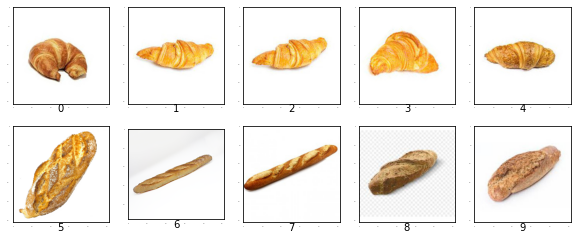

In [53]:
image_grid(sample(images))

### Réduction de la taille des images

In [54]:
for i, image in enumerate(images): images[i] = image.resize((64, 64), Image.ANTIALIAS)

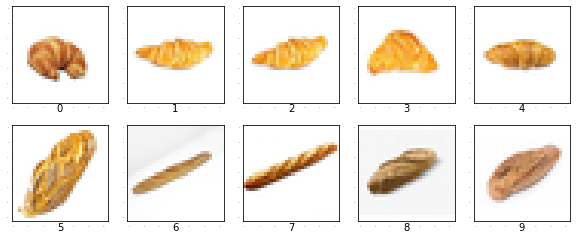

In [31]:
image_grid(sample(images))

### Unification de la profondeur des couleurs

    [PROBLÈME]: Les images possédent des profondeurs de couleurs (image depth) différentes.
    
    -> Aucune fonction de `utilities` ne fonctionne.

    [SOLUTION]: Unification de la profondeur

In [55]:
def change_color_depth(image, color_count=96):
    theta = 256 / color_count
    change = lambda value: math.trunc(value/theta)*theta
    return Image.fromarray(np.array(Image.eval(image, change))[:, :, :3])

In [57]:
images = images.apply(change_color_depth)

### Extraction de l'avant-plan

Après avoir essayé les filtres prédéfinis dans `utilities.py` avec différentes valeurs de `théta` (seuil), nous avons trouvé que `foreground_filter(img, theta=200)` convient. 

In [58]:
foreground = images.apply(my_foreground_filter)

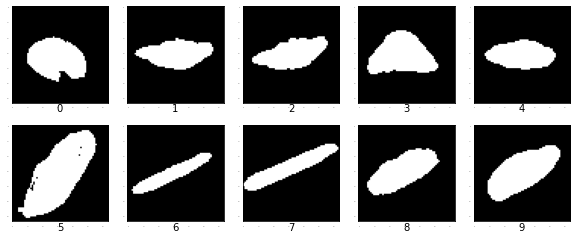

In [59]:
image_grid(sample(foreground))

### Extraction du contour

In [60]:
const = list(Image.fromarray(contours(fg)) for fg in foreground)

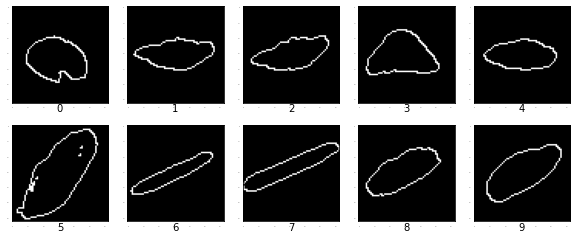

In [61]:
image_grid(sample(const))

## Attributs et visualisation

### `att_1` : Elongation

In [62]:
images_transparent = pd.Series(transparent_background(img, fg) for img, fg in zip(images, foreground))

In [63]:
c_elongation = images_transparent.apply(elongation)

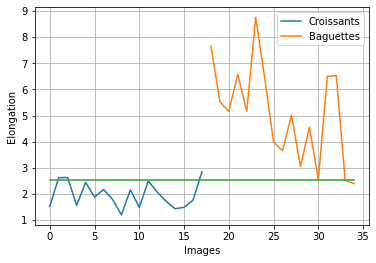

In [64]:
plot(c_elongation, 'Elongation')

### `att_2` : Redness

In [65]:
c_redness = images_transparent.apply(redness)

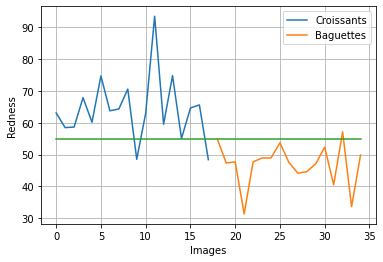

In [66]:
plot(c_redness, 'Redness')

### `att_3` : Thickness du milieu par rapport au bornes

#### Obtention des "image bounds"

In [89]:
def get_bounds(M: np.ndarray):
    for i, line in enumerate(M):
        if True in line: return i

#### Définition de l'attribut

In [88]:
def att_3(img: Image.Image):
    M = np.array(img)
    
    # Choix du L1 & L2
    i1, i2 = get_bounds(M), len(M) - get_bounds(np.flip(M, 0)) - 1
    img_dist = np.abs(i2 - i1)
    L1, L2 = M[int(i1 + img_dist*.25)], M[int(i2 - img_dist*.50)]
    

    dist1 = L1.tolist()[::-1].index(True) - L1.tolist().index(True)
    dist2 = L2.tolist()[::-1].index(True) - L2.tolist().index(True)
    return np.abs(dist1 - dist2)

#### Visualisation

In [94]:
c_att_1 = foreground.apply(att_1)

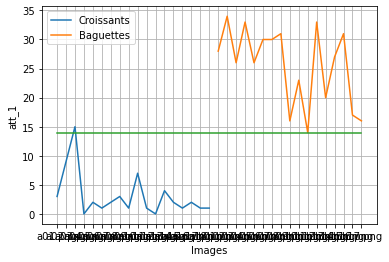

In [95]:
plot(c_att_1, 'att_1')

### `att_4` : Maximum pixels par colonne

#### Définition de l'attribut

In [96]:
def att_4(img: Image.Image):
    """Renvoie le maximum du nombre de pixels par colonne pour l'objet de l'image.
    
    [ASSUMPTION]: `img` est une image de color depth == 24 (donnée par images_uni_depth)"""
    
    foreground = foreground_filter(img, 200)    # Détection de l'objet
    M = np.transpose(np.array(foreground))
    sum_list = list()
    
    for line in M: sum_list.append(sum(line))
        
    return max(sum_list)

#### Visualisation

In [97]:
c_att_4 = images.apply(att_4)

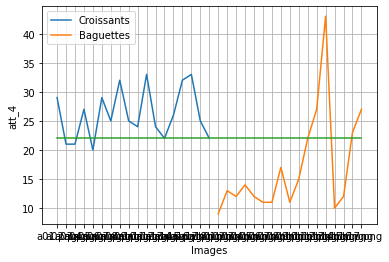

In [98]:
plot(c_att_4, 'att_4')

### `att_5` : Analyse mathématique de l'allure de l'objet

#### Extraction de l'allure de l'objet

On parcours l'image par colonnes après extraction de l'avant plan. En s'arrêtant lors du détection du premier pixel, on peut tracer une fonction mathématique qui modélise la forme du "dos" de l'objet.

##### Pour les croissants

- La fonction dérivée $\mid\frac{\displaystyle df}{\displaystyle dx}\mid$ prend des valeurs multiples et généralement varie entre $-\infty$ et $+\infty$

- L'intégrale de la fonction $\int f(x).dx$ est positive. Généralement d'ordre de $10^{2} pixels$.

##### Pour les baguettes

- La fonction dérivée $\mid\frac{\displaystyle df}{\displaystyle dx}\mid$ prend des valeurs très proches. Fonction quasiment constante.

- L'intégrale de la fonction $\int f(x).dx$ est nulle dans un voisinage de $a$ où $a = C_f \cap (y = x)$ le point d'intersection de la courbe avec l'axe des abscisses. Généralement d'ordre de $10^{-1} pixels$.

#### Visualisation

In [99]:
def get_upper_graph(img: Image.Image):
    
    # Setting up object variables
    foreground = foreground_filter(img, 200)    # Object detection
    M = np.array(foreground)    # Image matrix
    T = np.transpose(M)    # Image matrix transposed

    values_list = list()
    
    upper = get_bounds(M)    # Getting image bounds
    
    for i, column in enumerate(T):
        if True in column: values_list.append(column.tolist().index(True)-upper)
    
    Y_axis = - np.array(values_list)    # NOTE: Image axis and Mathematical axis are inverted
    
    # Translating the graph based on average value `<Y_axis>`
    return Y_axis + (max(Y_axis)-min(Y_axis))/2

In [101]:
def derivate(y_axis, x_axis=None):
    len_values = len(y_axis.tolist())
    d_x, d_y = list(), list()
    if x_axis == None: x_axis = np.arange(len_values)

    for i in range(len_values - 1):
        delta = x_axis[i+1] - x_axis[i]
        d_x.append((x_axis[i+1] + x_axis[i]) / 2.)
        d_y.append((y_axis[i+1] - y_axis[i]) / delta)
    
    # Optimizing for constant values (based on 1 neighb.)
    for i, val in enumerate(d_y):
        if i and not val: d_y[i] = d_y[i-1]

    return d_x, d_y

In [105]:
def att_5(img: Image.Image):
    func = get_upper_graph(img)
    _, d_y = derivate(func)
    return np.array(d_y).mean()

In [106]:
c_att_5 = images.apply(att_5)

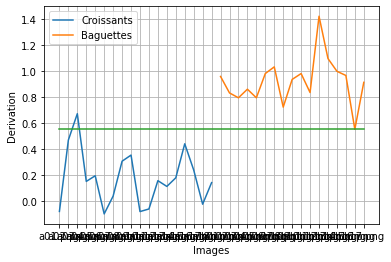

In [107]:
plot(c_att_5, 'Derivation')

## Classificateurs favoris

Les classificateurs performants sont neareast neighbors , linear svm , guassian process et neural net, avec un taux d'erreurs de 0% pour l'ensemble de tests et d'entraînement.

## Résultats

### Observations

In [68]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

model_name = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]
model_list = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [69]:
df_features = pd.read_csv('features_data.csv', index_col=0)

In [71]:
df_features.head()

,att_3,att_5,elongation,R-(G+B)/2,redness,class
a01.png,-0.873003,-1.440512,-0.941745,0.268676,0.594699,1
a02.png,-0.396820,-0.157494,-0.408384,1.101420,0.219402,1
a03.png,0.079364,0.316179,-0.407011,1.103339,0.234296,1
a04.png,-1.111095,-0.900906,-0.924329,1.790407,0.983591,1
a05.png,-0.952367,-0.799396,-0.495328,0.683803,0.356558,1


In [72]:
from sklearn.metrics import balanced_accuracy_score as sklearn_metric
compar_results = systematic_model_experiment(df_features, model_name, model_list, sklearn_metric)
compar_results.style.set_precision(2).background_gradient(cmap='Blues')

/tmp/ipykernel_109/960945060.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  compar_results.style.set_precision(2).background_gradient(cmap='Blues')


,perf_tr,std_tr,perf_te,std_te
Nearest Neighbors,1.00,0.00,1.00,0.00
Linear SVM,1.00,0.00,1.00,0.00
RBF SVM,1.00,0.00,0.90,0.07
Gaussian Process,1.00,0.00,1.00,0.00
Decision Tree,1.00,0.00,0.93,0.03
Random Forest,1.00,0.00,0.97,0.04
Neural Net,1.00,0.00,1.00,0.00
AdaBoost,1.00,0.00,0.92,0.04
Naive Bayes,1.00,0.00,0.97,0.04
QDA,1.00,0.00,0.93,0.04


    -> Quatre classificateurs très performants avec un taux d'erreurs de 0% , nos attributs sont capable de classifier notre jeu de donnée.

### Interprétations

In [73]:
analyze_model_experiments(compar_results)

,perf_tr,std_tr,perf_te,std_te,Overfitted,Underfitted
Nearest Neighbors,1.000000,0.000000,1.000000,0.000000,False,False
Linear SVM,1.000000,0.000000,1.000000,0.000000,False,False
RBF SVM,1.000000,0.000000,0.900000,0.069389,True,False
Gaussian Process,1.000000,0.000000,1.000000,0.000000,False,False
Decision Tree,1.000000,0.000000,0.933333,0.033333,True,False
Random Forest,1.000000,0.000000,0.972222,0.044790,False,False
Neural Net,1.000000,0.000000,1.000000,0.000000,False,False
AdaBoost,1.000000,0.000000,0.922222,0.044444,True,False
Naive Bayes,1.000000,0.000000,0.966667,0.036851,True,False
QDA,1.000000,0.000000,0.927778,0.043390,True,False


Après analyse des performances des classificateurs:

Les classificateurs qui ont sur-appris sont `RBF SVM` , `DEcision Tree` , `Random forest` , `AdaBOOST`, et `QDA`

Il n'y a pas de classificatteurs qui ont sous-appris.

#### Comité de classificateurs et incertitude

In [74]:
class ClassifierCommittee():
    def __init__(self, model_list):
        self.model_list = model_list
        
    def fit(self,X,y):
        for model in self.model_list:
            model.fit(X,y)
    def predict(self,X):
        predictions = []
        for model in self.model_list:
            predictions.append(model.predict(X))
        predictions = np.mean(np.array(predictions),axis = 0)
        results = []
        for v in predictions:
            if v < 0:
                results.append(-1)
            else:
                results.append(1)
        return np.array(results)
    
    def predict_proba(self,X):
        predictions = []
        for model in self.model_list:
            predictions.append(model.predict_proba(X))
        return np.swapaxes(np.array(predictions), 0, 1)
    def score(self,X):
        scores = []
        for model in self.model_list:
            scores.append(model.score(X,y))
        return np.swapaxes(np.array(scores), 0, 1)

In [75]:
commitee = ClassifierCommittee(model_list)
perf_tr, std_tr, perf_te, std_te = df_cross_validate(df_features, commitee, sklearn_metric)
print(f'{perf_te = }\n {std_te = }')

perf_te = 0.9888888888888889
 std_te = 0.022222222222222233


On a eu un taux d'erreur de 0.014% pour l'ensemble de tests.

#### Incertitude aléatorique et epistémique

In [77]:
X = df_features.iloc[:, :-1].to_numpy()
Y = df_features.iloc[:, -1].to_numpy()
commitee.fit(X, Y)
prediction_probabilities = commitee.predict_proba(X)

In [80]:
from scipy.stats import entropy
entropies_per_classifier = entropy(np.swapaxes(prediction_probabilities, 0, 2))
entropies = np.mean(entropies_per_classifier, axis = 0)
df_uncertainty = pd.DataFrame({"images" : images,
                           "entropy" : entropies})
df_uncertainty = df_uncertainty.sort_values(by=['entropy'],ascending=False)

In [84]:
# std entre les classses
epistemic_uncertainty = np.std(prediction_probabilities, axis = 2)
# mean entre les classificateurs
epistemic_uncertainty = np.mean(epistemic_uncertainty, axis = 1)

In [85]:
df_uncertainty["std_epistemic"] = epistemic_uncertainty
df_uncertainty = df_uncertainty.sort_values(by=['std_epistemic'],ascending=False)
df_uncertainty.head(7).style.background_gradient(cmap='RdYlGn_r')

,images,entropy,std_epistemic
b10.png,,0.054653,0.486998
a02.png,,0.102195,0.486228
a07.png,,0.056749,0.485774
b13.png,,0.136339,0.484903
b09.png,,0.125703,0.484221
b05.png,,0.070190,0.484102
a03.png,,0.341317,0.483745


Les valeurs d'incertitude aléatorique (entropie) et épistémiques (std) ne semblent pas très corrélées

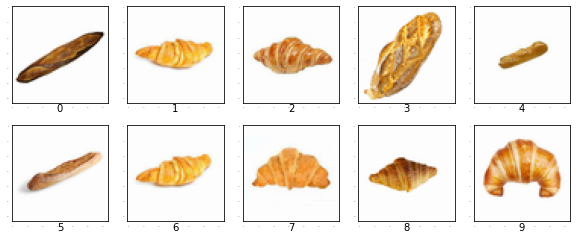

In [87]:
uncertain_epistemic_images = df_uncertainty['images'].tolist()
# les images où les classificateurs sont le moins d'accord
image_grid(uncertain_epistemic_images[:10])

## Conclusion et discussions

### Applicabilité et scaling en vie réel

### Difficultés rencontrées